# Advanced Topics in Word Embeddings

## NYCDH Week, February 2019

This notebook originally accompanied a workshop I gave at NYCDH Week, in February of 2019, called "Advanced Topics in Word Embeddings." It's only somewhat advanced, and with a little background in NLP, could even serve as a good introduction to the subject.

Here are some more resources for getting started with thinking about word embeddings: 

- [A classic primer on Word Embeddings, from Google (uses TensorFlow)](https://www.tensorflow.org/tutorials/representation/word2vec)
- [Another word2vec tutorial using TensorFlow](https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/)
- [The original documentation of word2vec](https://code.google.com/archive/p/word2vec/)
- [Spacy Docs on vector similarity](https://spacy.io/usage/vectors-similarity)
- [Gensim Docs](https://radimrehurek.com/gensim/models/keyedvectors.html)

And for getting started in NLP more generally, here are two notebooks of mine: 

- [Introduction to Text Analysis](https://github.com/JonathanReeve/dataviz-workshop-2017)
- [Advanced Text Analysis Workshop](https://github.com/JonathanReeve/advanced-text-analysis-workshop-2017)

## An Example of Document Vectors: Project Gutenberg

This figure shows off some of the things you can do with document vectors. Using just the averaged word vectors of each document, and projecting them onto PCA space, you can see a nice divide between fiction and nonfiction books. In fact, I like to think of the line connecting the upper-left and the lower-right as a vector of "fictionality," withthe upper-left corner as "highly fictional," and the lower right as "highly non-fictional." Curiously, religious texts are right in between. 

![First 30 Books of Project Gutenberg](example-gut.png)

## Getting Started

First, import the libraries below. (Make sure you have the packages beforehand, of course.)

In [20]:
import pandas as pd
import spacy
from glob import glob
# import word2vec
# import gensim
# from gensim.test.utils import common_texts
# from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import json
from mpl_toolkits.mplot3d import Axes3D, proj3d #???
from numpy import dot
from numpy.linalg import norm
%matplotlib notebook
plt.rcParams["figure.figsize"] = (12,8)

Now load the Spacy data that you downloaded (hopefully) prior to the workshop. If you don't have it, or get an error below, you might want to [check out the documentation that Spacy maintains here](https://spacy.io/models/en#en_vectors_web_lg) for how to download language models. Download the `en_core_web_lg` model. 

In [21]:
nlp = spacy.load('en_core_web_lg')

# Word Vector Similarity

First, let's make SpaCy "document" objects from a few expressions. These are fully parsed objects that contain lots of inferred information about the words present in the document, and their relations. For our purposes, we'll be looking at the `.vector` property, and comparing documents using the `.similarity()` method. The `.vector` is just an average of the word vectors in the document, where each word vector comes from pre-trained model—the Stanford GloVe vectors. Just for fun, I've taken the examples below from _Monty Python and the Holy Grail_, the inspiration for the name of the Python programming language. ([If you haven't seen it, this is the scene I'm referencing.](https://www.youtube.com/watch?v=liIlW-ovx0Y).) 

In [22]:
africanSwallow = nlp('African swallow')
europeanSwallow = nlp('European swallow')
coconut = nlp('coconut')

In [28]:
africanSwallow.similarity(europeanSwallow)

0.8596378859289445

In [29]:
africanSwallow.similarity(coconut)

0.2901231866716321

The `.similarity()` method is nothing special. We can implement our own, using dot products and norms: 

In [30]:
def similarity(vecA, vecB):
    return dot(vecA, vecB) / (norm(vecA, ord=2) * norm(vecB, ord=2))

In [31]:
similarity(africanSwallow.vector, europeanSwallow.vector)

0.8596379

# Analogies (Linear Algebra)

In fact, using our custom similarity function above is probably the easiest way to do word2vec-style vector arithmetic (linear algebra). What will we get if we subtract "European swallow" from "African swallow"? 

In [32]:
swallowArithmetic = (africanSwallow.vector - europeanSwallow.vector)

To find out, we can make a function that will find all words with vectors that are most similar to our vector. If there's a better way of doing this, let me know! I'm just going through all the possible words (all the words in `nlp.vocab`) and comparing them. This should take a long time.

In [34]:
def mostSimilar(vec):
    highestSimilarities = [0]
    highestWords = [""]
    for w in nlp.vocab:
        sim = similarity(vec, w.vector)
        if sim > highestSimilarities[-1]:
            highestSimilarities.append(sim)
            highestWords.append(w.text.lower())
    return list(zip(highestWords, highestSimilarities))[-10:]

In [35]:
mostSimilar(swallowArithmetic)

/nix/store/dwk28xfqz64hvdbc3a0ydh4hpgp57zbc-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


[('croup', 0.06349668),
 ('deceased', 0.11223719),
 ('jambalaya', 0.14376064),
 ('cobra', 0.17929554),
 ('addax', 0.18801448),
 ('tanzania', 0.25093195),
 ('rhinos', 0.3014531),
 ('lioness', 0.34080425),
 ('giraffe', 0.37119308),
 ('african', 0.5032688)]

Our most similar word here is "african"! So "European swallow" - "African swallow" = "African"! Just out of curiosity, what will it say is the semantic neighborhood of "coconut"?

In [36]:
mostSimilar(coconut.vector)

/nix/store/dwk28xfqz64hvdbc3a0ydh4hpgp57zbc-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


[('jambalaya', 0.24809697),
 ('tawny', 0.2579049),
 ('concentrate', 0.35225457),
 ('lasagna', 0.36302277),
 ('puddings', 0.4095627),
 ('peel', 0.47492552),
 ('eucalyptus', 0.4899935),
 ('carob', 0.57747585),
 ('peanut', 0.6609557),
 ('coconut', 1.0000001)]

Looks like a recipe space. Let's try the classic word2vec-style analogy, king - man + woman = queen:  

In [38]:
king, queen, woman, man = [nlp(w).vector for w in ['king', 'queen', 'woman', 'man']]

In [39]:
answer = king - man + woman

In [40]:
mostSimilar(answer)

/nix/store/dwk28xfqz64hvdbc3a0ydh4hpgp57zbc-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


[('gorey', 0.03473952),
 ('deceased', 0.2673984),
 ('peasant', 0.32680285),
 ('guardian', 0.3285926),
 ('comforter', 0.346274),
 ('virgins', 0.3561441),
 ('kissing', 0.3649173),
 ('woman', 0.5150813),
 ('kingdom', 0.55209804),
 ('king', 0.802426)]

It doesn't work quite as well as expected. What about for countries and their capitals? Paris - France + Germany = Berlin? 

In [41]:
paris, france, germany = [nlp(w).vector for w in ['Paris', 'France', 'Germany']]
answer = paris - france + germany
mostSimilar(answer)

/nix/store/dwk28xfqz64hvdbc3a0ydh4hpgp57zbc-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


[('orlando', 0.48517892),
 ('dresden', 0.51174784),
 ('warsaw', 0.5628617),
 ('stuttgart', 0.5869507),
 ('vienna', 0.6086052),
 ('prague', 0.6289497),
 ('munich', 0.6677783),
 ('paris', 0.6961337),
 ('berlin', 0.75474036),
 ('germany', 0.8027713)]

It works! If you ignore the word itself ("Germany"), then the next most similar one is "Berlin"!

# Pride and Prejudice

Now let's look at the first bunch of nouns from _Pride and Prejudice_. It starts: 

    It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.
    However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.
    
First, load and process it. We'll grab just the first fifth of it, so we won't run out of memory. (And if you still run out of memory, maybe increase that number.)

In [42]:
pride = open('pride.txt').read()

In [48]:
pride = pride[:int(len(pride)/5)]

In [49]:
prideDoc = nlp(pride)

Now grab the first, say, 40 nouns. 

In [50]:
prideNouns = [w for w in prideDoc if w.pos_.startswith('N')][:40]
prideNounLabels = [w.lemma_ for w in prideNouns]

In [51]:
prideNounLabels[:10]

['truth',
 'man',
 'possession',
 'fortune',
 'want',
 'wife',
 'feeling',
 'view',
 'man',
 'neighbourhood',
 'truth',
 'mind',
 'family',
 'property',
 'one',
 'daughter',
 '”',
 'lady',
 'one',
 'day',
 'answer',
 'who',
 'wife',
 'objection',
 'invitation',
 'dear',
 'man',
 'fortune',
 'north',
 'chaise',
 'four',
 'place',
 'possession',
 'servant',
 'house',
 'end',
 'week',
 'what',
 'name',
 'dear']

Get the vectors of those nouns. 

In [53]:
prideNounVecs = [w.vector for w in prideNouns]

Verify that they are, in fact, our 300-dimensional vectors.

In [55]:
prideNounVecs[0].shape

(300,)

Use PCA to reduce them to three dimensions, just so we can plot them.

In [54]:
reduced = PCA(n_components=3).fit_transform(prideNounVecs)

In [56]:
reduced[0].shape

(3,)

In [57]:
prideDF = pd.DataFrame(reduced)

Plot them interactively, in 3D, just for fun. 

In [58]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,8)

def plotResults3D(df, labels): 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df[0], df[1], df[2], marker='o')
    for i, label in enumerate(labels):
        ax.text(df.loc[i][0], df.loc[i][1], df.loc[i][2], label)

<IPython.core.display.Javascript object>


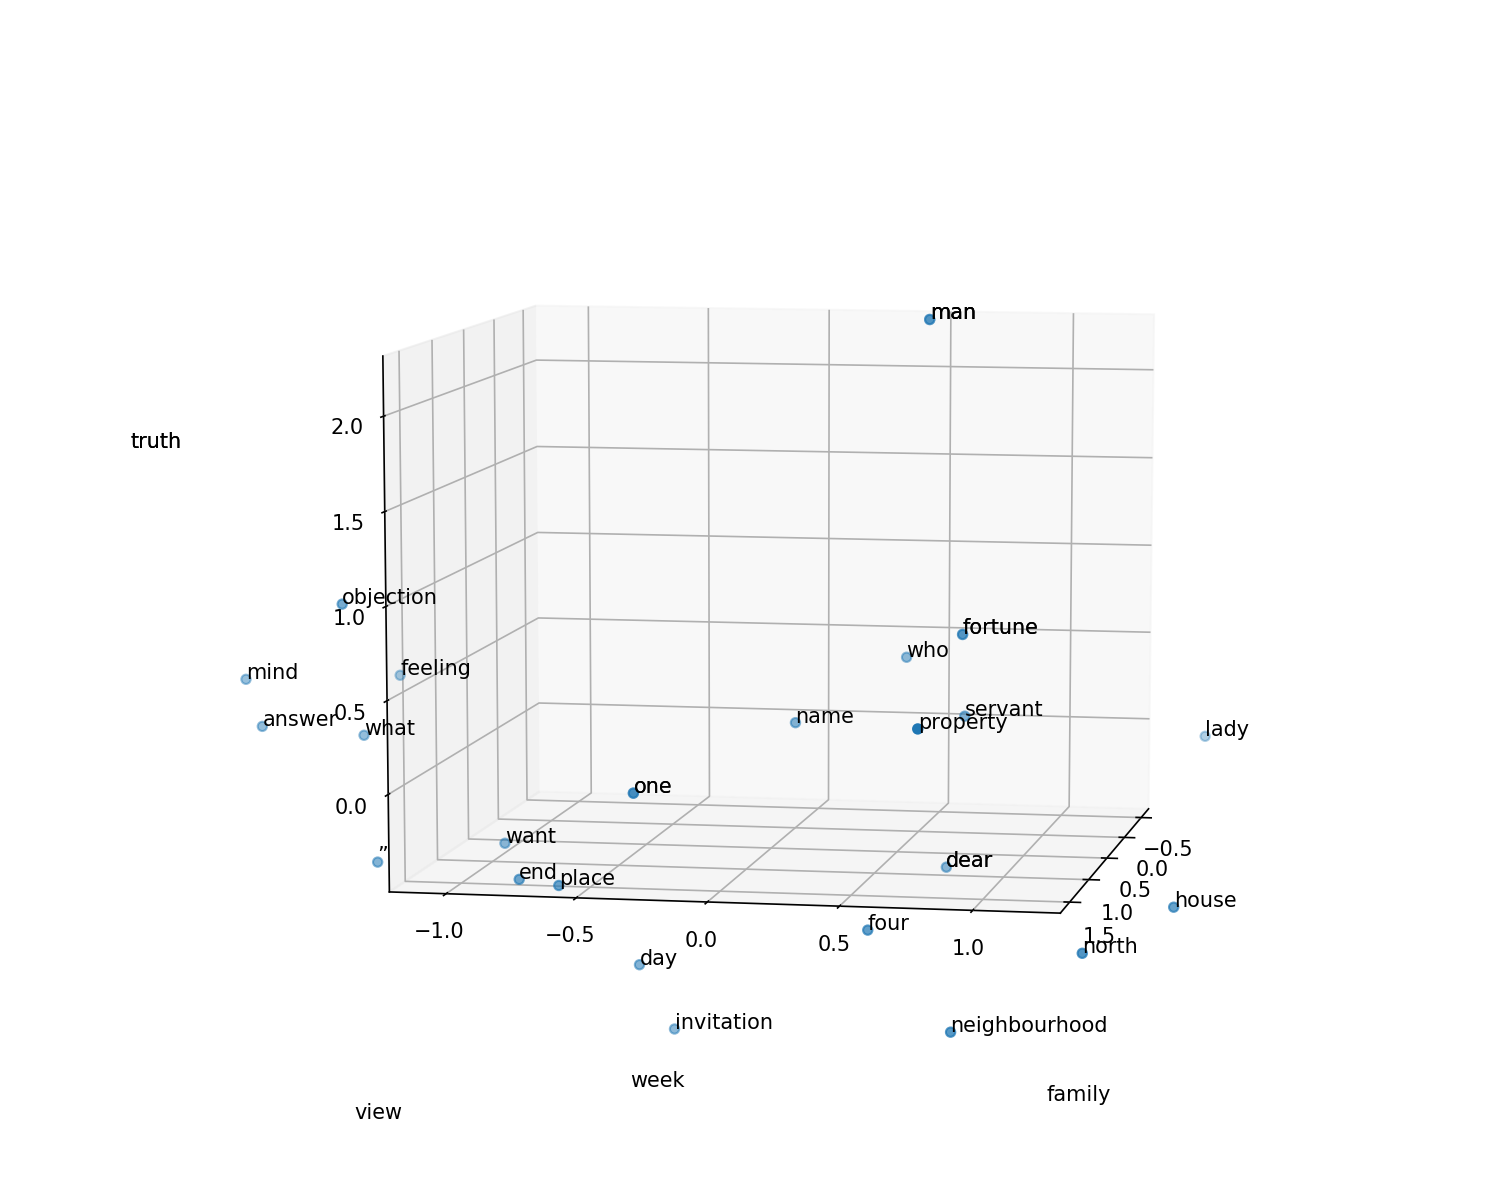

In [59]:
plotResults3D(prideDF, prideNounLabels)

Now we can rewrite the above function so that instead of cycling through all the words ever, it just looks through all the _Pride and Prejudice_ nouns: 

In [60]:
# Redo this function with only nouns from Pride and Prejudice
def mostSimilar(vec):
    highestSimilarities = [0]
    highestWords = [""]
    for w in prideNouns:
        sim = similarity(vec, w.vector)
        if sim > highestSimilarities[-1]:
            highestSimilarities.append(sim)
            highestWords.append(w.text.lower())
    return list(zip(highestWords, highestSimilarities))[-10:]

Now we can investigate, more rigorously than just eyeballing the visualization above, the vector neighborhoods of some of these words: 

In [62]:
mostSimilar(nlp('fortune').vector)

[('', 0), ('truth', 0.3837785), ('man', 0.40059176), ('fortune', 1.0000001)]

# Senses

If we treat words as documents, and put them in the same vector space as other documents, we can infer how much like that word the document is, vector-wise. Let's use four words representing the senses: 

In [63]:
senseDocs = [nlp(w) for w in ['sound', 'sight', 'touch', 'smell']]
def whichSense(word):
    doc = nlp(word)
    return {sense: doc.similarity(sense) for sense in senseDocs}

In [64]:
whichSense('symphony')

{sound: 0.37716483832358116,
 sight: 0.20594014841156277,
 touch: 0.19551651130481998,
 smell: 0.19852637065751555}

In [65]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,8)

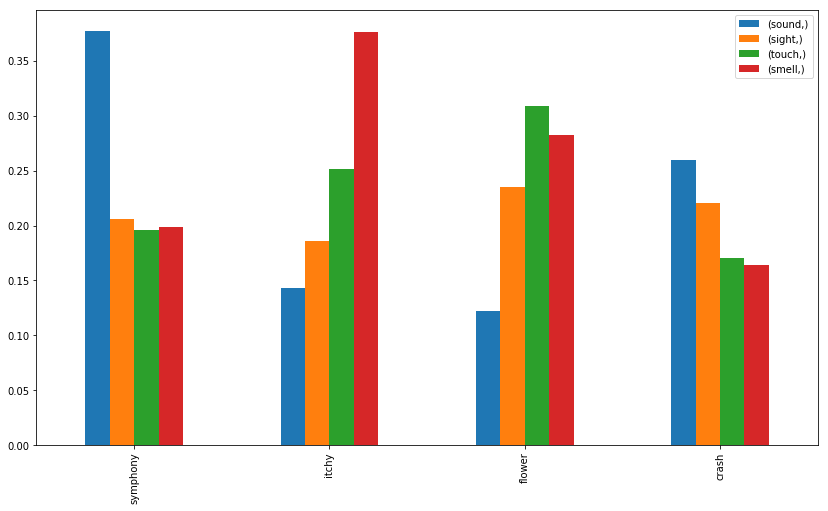

In [66]:
testWords = 'symphony itchy flower crash'.split()
pd.DataFrame([whichSense(w) for w in testWords], index=testWords).plot(kind='bar')

It looks like it correctly guesses that _symphony_ correlates with _sound_, and also does so with _crash_, but its guesses for _itchy_ (_smell_) and for _flower_ (_touch_) are less intuitive.

# The Inaugural Address Corpus

In this repo, I've prepared a custom version of the Inaugural Address Corpus included with the NLTK. It just represents the inaugural addresses of most of the US presidents from the 20th and 21st centuries. Let's compare them using document vectors! First let's generate parallel lists of documents, labels, and other metadata: 

In [69]:
inauguralFilenames = sorted(glob('inaugural/*'))
inauguralLabels = [fn[10:-4] for fn in inauguralFilenames]
inauguralDates = [int(label[:4]) for label in inauguralLabels]
parties = 'rrrbbrrrbbbbbrrbbrrbrrrbbrrbr' # I did this manually. There are probably errors.
inauguralRaw = [open(f, errors="ignore").read() for f in inauguralFilenames]

In [70]:
# Sanity check: peek
for i in range(4): 
    print(inauguralLabels[i][:30], inauguralDates[i], inauguralRaw[i][:30])

1901-McKinley 1901 My fellow-citizens, when we as
1905-Roosevelt 1905 My fellow citizens, no people 
1909-Taft 1909 My fellow citizens: Anyone who
1913-Wilson 1913 There has been a change of gov


Process them and compute the vectors: 

In [71]:
inauguralDocs = [nlp(text) for text in inauguralRaw]

In [72]:
inauguralVecs = [doc.vector for doc in inauguralDocs]

Now compute a similarity matrix for them. Check the similarity of everything against everything else. There's probably a more efficient way of doing this, using sparse matrices. If you can improve on this, please send me a pull request!

In [73]:
similarities = []
for vec in inauguralDocs: 
    thisSimilarities = [vec.similarity(other) for other in inauguralDocs]
    similarities.append(thisSimilarities)

In [74]:
df = pd.DataFrame(similarities, columns=inauguralLabels, index=inauguralLabels)

Now we can use `.idmax()` to compute the most semantically similar addresses. 

In [75]:
df[df < 1].idxmax()

1901-McKinley        1925-Coolidge
1905-Roosevelt         1913-Wilson
1909-Taft            1901-McKinley
1913-Wilson         1905-Roosevelt
1917-Wilson         1905-Roosevelt
1921-Harding       1953-Eisenhower
1925-Coolidge       1933-Roosevelt
1929-Hoover          1901-McKinley
1933-Roosevelt       1925-Coolidge
1937-Roosevelt      1933-Roosevelt
1941-Roosevelt      1937-Roosevelt
1945-Roosevelt        1965-Johnson
1949-Truman           1921-Harding
1953-Eisenhower    1957-Eisenhower
1957-Eisenhower    1953-Eisenhower
1961-Kennedy            2009-Obama
1965-Johnson            1969-Nixon
1969-Nixon            1965-Johnson
1973-Nixon             1981-Reagan
1977-Carter             2009-Obama
1981-Reagan            1985-Reagan
1985-Reagan            1981-Reagan
1989-Bush             1965-Johnson
1993-Clinton            2017-Trump
1997-Clinton           1985-Reagan
2001-Bush              1981-Reagan
2005-Bush          1953-Eisenhower
2009-Obama             1981-Reagan
2017-Trump          

If we reduce the dimensions here using PCA, we can visualize the similarity in 2D: 

In [76]:
embedded = PCA(n_components=2).fit_transform(inauguralVecs)

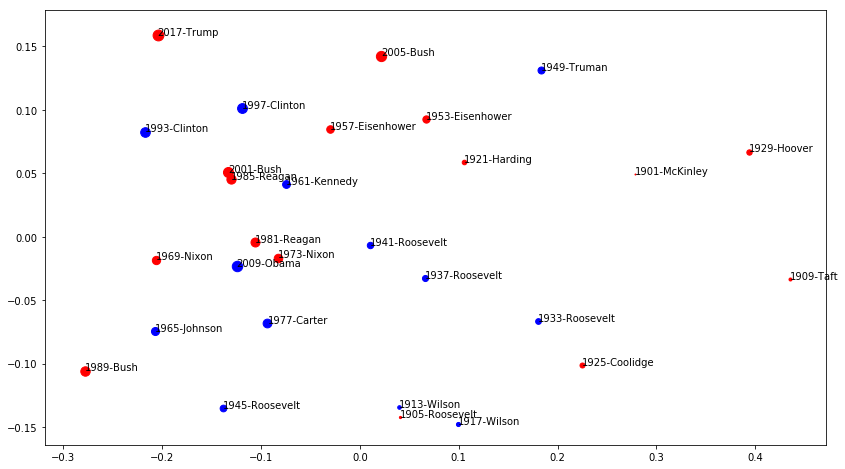

In [77]:
xs, ys = embedded[:,0], embedded[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i], c=parties[i], s=inauguralDates[i]-1900)
    plt.annotate(inauguralLabels[i], (xs[i], ys[i]))

# Detective Novels

I've prepared a corpus of detective novels, using another notebook in this repository. It contains metadata and full texts of about 10 detective novels. Let's compute their similarities to certain weapons! It seems the murder took place in the drawing room, with a candlestick, and the murderer was [Colonel Mustard](https://en.wikipedia.org/wiki/List_of_Cluedo_characters#Colonel_Mustard)!

In [79]:
detectiveJSON = open('detectives.json')
detectivesData = json.load(detectiveJSON)
detectivesData = detectivesData[1:] # Chop off #1, which is actually a duplicate

In [80]:
detectiveTexts = [book['text'] for book in detectivesData]

We might want to truncate these texts, so that we're comparing the same amount of text throughout. 

In [81]:
detectiveLengths = [len(text) for text in detectiveTexts] 
detectiveLengths

[351240, 415961, 440629, 611531, 399572, 242949, 648486, 350142, 288955]

In [82]:
detectiveTextsTruncated = [t[:min(detectiveLengths)] for t in detectiveTexts]

In [83]:
detectiveDocs = [nlp(book) for book in detectiveTextsTruncated] # This should take a while

In [84]:
extraWords = "gun knife snake diamond".split()
extraDocs = [nlp(word) for word in extraWords]
extraVecs = [doc.vector for doc in extraDocs]

In [85]:
detectiveVecs = [doc.vector for doc in detectiveDocs]
detectiveLabels = [doc['author'].split(',')[0] +  '-' + doc['title'][:20] for doc in detectivesData]

In [86]:
detectiveLabels

['Collins-The Haunted Hotel: A',
 'Rohmer-The Insidious Dr. Fu',
 'Chesterton-The Innocence of Fat',
 'Doyle-The Return of Sherlo',
 'Chesterton-The Wisdom of Father',
 'Doyle-A Study in Scarlet',
 "Gaboriau-The Count's Millions",
 "Rinehart-Where There's a Will",
 "Michelson-In the Bishop's Carr"]

In [88]:
pcaOut = PCA(n_components=10).fit_transform(detectiveVecs + extraVecs)
tsneOut = TSNE(n_components=2).fit_transform(pcaOut)

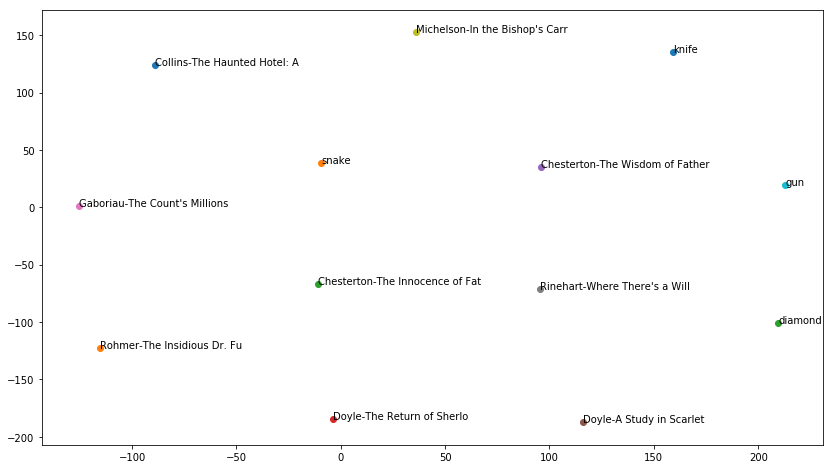

In [89]:
xs, ys = tsneOut[:,0], tsneOut[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i])
    plt.annotate((detectiveLabels + extraWords)[i], (xs[i], ys[i]))

If you read the summaries of some of these novels on Wikipedia, this isn't terrible. To check, let's just see how often these words occur in the novels. 

In [90]:
# Sanity check
counts = {label: {w: 0 for w in extraWords} for label in detectiveLabels}
for i, doc in enumerate(detectiveDocs):
    for w in doc: 
        if w.lemma_ in extraWords: 
            counts[detectiveLabels[i]][w.lemma_] += 1

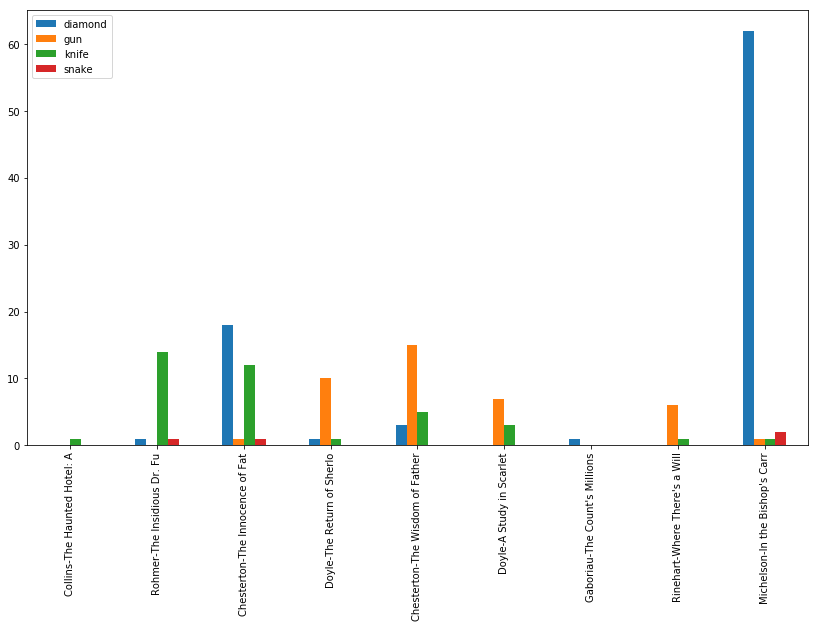

In [91]:
pd.DataFrame(counts).T.plot(kind='bar')

# Train Your Own

We won't actually have time to do this, but if you want to train your own vector space, you can do so with word2vec, like this. For this to work, you'll have to uncomment the lines in the import block above, as well. 

In [ ]:
# Requires Gensim. See commented-out imports above.
# model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)

In [ ]:
# word_vectors = model.wv